### Import some useful pkgs

In [1]:
import os
import sys
import time
module_path = os.path.abspath(os.path.join('../mypkg'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [13]:
from tqdm import trange, tqdm

import torch
import torch.nn as nn 
import torch.nn.functional as F 
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sklearn.preprocessing import minmax_scale

import numpy as np
import xarray as xr
from easydict import EasyDict as edict
from pathlib import Path
import pickle
import scipy

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import json

#### Reload my modules

In [20]:
import importlib

import utils.misc
importlib.reload(utils.misc);
from utils.misc import mag2db, meg_psd2spatialfeature, get_mode

from utils.standardize import std_psd, std_vec, minmax_vec

import sgm.sgm
importlib.reload(sgm.sgm);
from sgm.sgm import SGM


from spectrome import Brain, path, functions

import constants
importlib.reload(constants)
from constants import RES_ROOT, FIG_ROOT, DAT_ROOT

### Some functions

In [21]:
get_mode_wrap = lambda x: np.array([get_mode(x.numpy()[:, iy]) for iy in range(7)])

### Load real data PSD and brain

#### PSD and connectome

In [22]:
# Load data
ind_psd_xr = xr.open_dataarray(DAT_ROOT/'individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
freqs = ind_psd_xr["frequencies"].values
ind_conn_xr = xr.open_dataarray(DAT_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values


#### data for brain plots

In [26]:
# Get reorder indeix
# dk86.***.txt is the order for the MEG data
# DK68_labelorder.xlsx is the order for the template
dk_brainnet = pd.read_excel(DAT_ROOT/"DK68_labelorder.xlsx")
with open(DAT_ROOT/'dk86atlas_regions_python.txt') as f:
    dk_python = f.readlines()
    
brainnet_order = dk_brainnet["Order in Brainstorm"]
dk_python_renamed = []
brainnet_renamed = []

for i in range(len(dk_python)):
    sp1 = dk_python[i].split('=')
    sp2 = sp1[1].split('_')
    dk_python_renamed.append((sp2[0] + ' ' + sp2[1]).lower().strip())

for i in range(len(brainnet_order)):
    brainnet_renamed.append((brainnet_order[i].replace("'","")).lower())

d = {x: a for a, x in enumerate(dk_python_renamed[0:68])}
orderedind = np.array([d[x] for x in brainnet_renamed])

In [37]:
def reorderU(wU):
    wUreorder = wU.copy()
    wUreorder = wUreorder[orderedind]
    return wUreorder

with open(DAT_ROOT/'BNVtemplate_DK68.txt', "r") as tf:
    DKtmplateRaw = tf.readlines()
DKtmplate = np.array([int(x.strip()) for x in DKtmplateRaw])

def U2BrainVec(wU):
    emVec = np.zeros_like(DKtmplate, dtype=np.float64)
    for idx in range(1, 69):
        emVec[DKtmplate==idx] = wU[idx-1]
    return emVec

#### Load parul's results

In [31]:
anl_res = pd.read_csv(DAT_ROOT/"./parul_results.csv")

### Set up Parameters

#### Set up plotting

In [11]:
metd = edict()
metd.SBI = "SBI-SGM"
metd.anl = "Ann-SGM"

plot_sets = edict()
plot_sets.col = ["dodgerblue", "coral"]
plot_sets.alpha = 0.8
plot_sets.marker = ["o", "h"]

#### Parameters

In [32]:
paras = edict()
paras.noise_sd = 0.2
paras.num_prior_sps = int(1e5)
paras.path = Path(RES_ROOT/"./main_results_nsf")

paras.robustParas = edict()
paras.robustParas.num_rep = 100
paras.robustParas.noise_sd = 0.2
paras.robustParas.num_prior_sps = int(1e5)
paras.robustParas.path = Path(paras.path/"robust_results")

paras.tuningParas = edict()
paras.tuningParas.noise_sd = 0.2
paras.tuningParas.num_prior_sps = int(1e5)
paras.tuningParas.path = Path(paras.path/"tuning_results")

paras.fig_dir = FIG_ROOT
paras.res_dir = RES_ROOT
paras.name_order = ['taue','taui','tauG','speed','alpha','gii','gei']
paras.name_order_latex = [r'$\tau_e$',r'$\tau_i$',r'$\tau_G$',r'$v$',r'$\alpha$',r'$g_{ii}$',r'$g_{ei}$']

In [33]:
#v_lower = 3.5-1.8
#v_upper = 3.5+1.8
#bnds = ((5.0,30.0), (5.0,200.0), (0.1,1.0), (v_lower,v_upper), (0.5,10.0), (0.5,10.0), (5.0,30.0))
#This is the order for the above bounds:  tau_e, tau_i, alpha, speed, gei, gii, tauC,

# taue, taui, tauC, speed, alpha, gii, gei
par_low = np.asarray([0.005,0.005,0.005,1.7,0.1,0.5,0.5])
par_high = np.asarray([0.03, 0.20, 0.03,5.3,  1, 10, 10])
plotLimits = np.array([par_low, par_high]).T

In [34]:
# obtain the brain
brain = Brain.Brain()
brain.add_connectome(DAT_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

sgmmodel = SGM(brain.reducedConnectome, brain.distance_matrix, freqs)

### SBI way

####  Load files

In [35]:
fils = list(paras.robustParas.path.glob("robustSps_100000_sd20_*.pkl"))

tmpSortFn = lambda p: int(p.stem.split("_")[-1])
sorted_fils = sorted(fils, key=tmpSortFn)

#### Get the posterior samples

(once saved, do not need to run again)

In [45]:
for ixfil in tqdm(sorted_fils[:]):
    with open(ixfil, "rb") as f:
        curRes = pickle.load(f)
        
    ix = tmpSortFn(ixfil)
    postSpss = []
    for iy in range(ind_psd.shape[-1]):
        curC = ind_conn[:, :, iy]
        curBrain = Brain.Brain()
        curBrain.add_connectome(data_dir) # grabs distance matrix
        # re-ordering for DK atlas and normalizing the connectomes:
        curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
        curBrain.connectome = curC# re-assign connectome to individual connectome
        curBrain.bi_symmetric_c()
        curBrain.reduce_extreme_dir()
        
        sp, raw_sps = meg_psd2spatialfeature(curBrain.reducedConnectome, ind_psd[:, :, iy], freqs, band="alpha")
        stdSp = std_vec(raw_sps.sum(axis=1))
        stdPsd = std_psd(mag2db(ind_psd[:, :, iy])).flatten()
        curX = torch.Tensor(np.concatenate([stdPsd, stdSp]))
        postSps = curRes.posterior.sample((10000, ), x=curX, max_sampling_batch_size=100000)
        postSpss.append(postSps)
        
    
    curRes.postSpss = postSpss
    with open(ixfil, "wb") as f:
        pickle.dump(curRes, f)

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 6/10 [00:04<00:02,  1.54it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

/home/hujin/.local/lib/python3.9/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  outputs, _ = torch.triangular_solve(


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 7/10 [00:59<00:55, 18.63s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 8/10 [01:38<00:49, 24.96s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9994 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9998 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9905 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 9/10 [22:43<06:52, 412.65s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [24:28<00:00, 146.83s/it]


#### Point estimates of the parameters

In [17]:
estParass = []
for ixfil in tqdm(sorted_fils[:]):
    with open(ixfil, "rb") as f:
        curRes = pickle.load(f)
    estParass.append(np.array([np.median(postSps.numpy(), axis=0) for postSps in curRes.postSpss]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.07it/s]


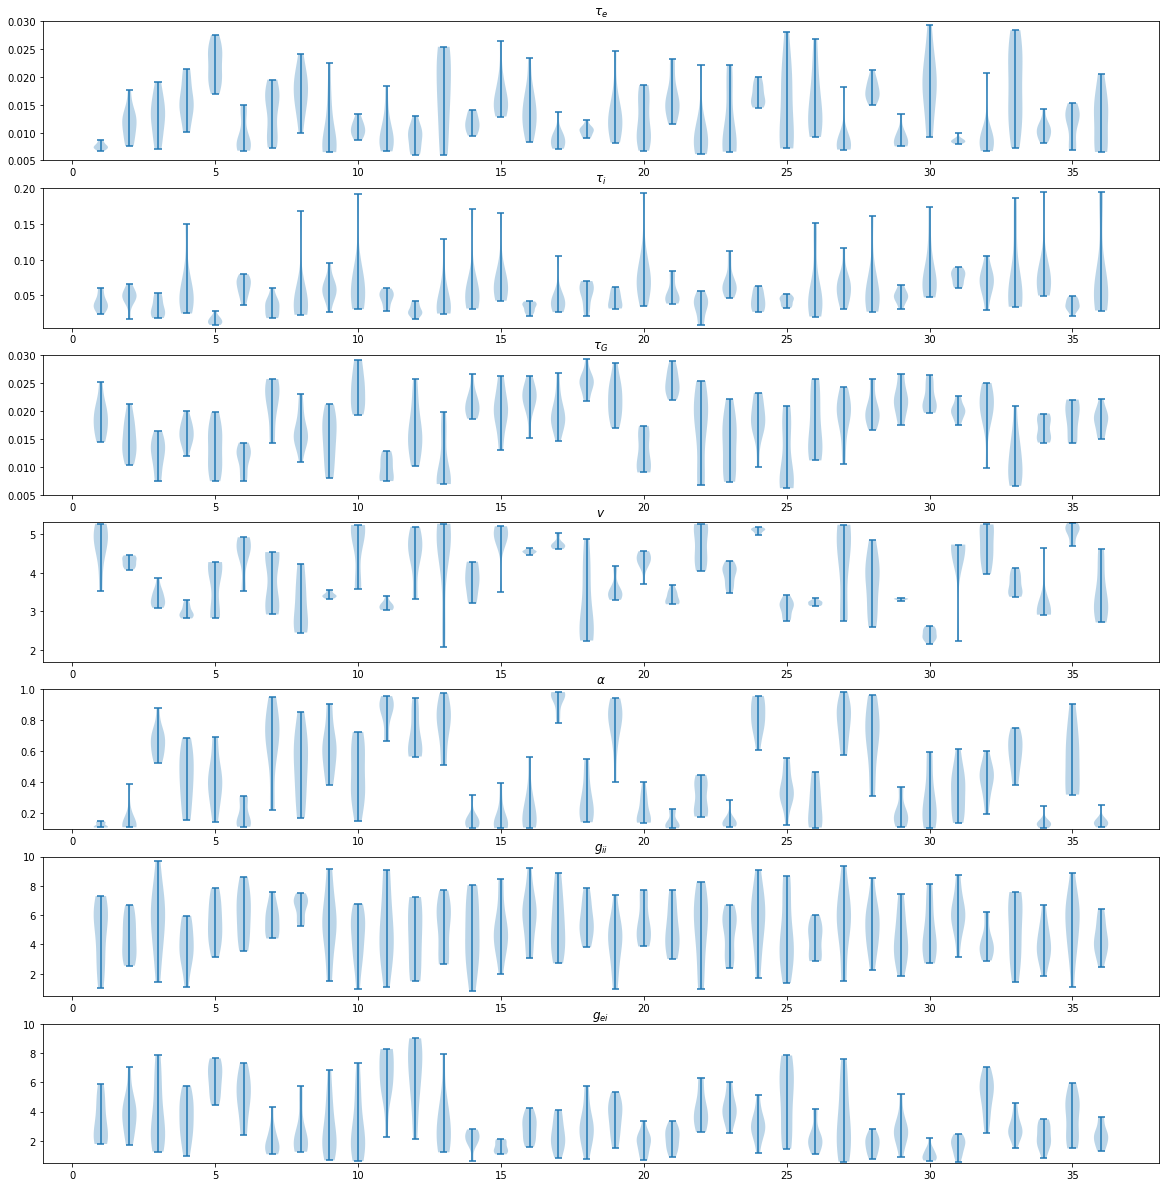

In [24]:
plotLimits = np.array([par_low, par_high]).T
labels=['taue','taui','tauG','speed','alpha','gii','gei']
labels= paras.name_order_latex
estParass = np.array(estParass)
plt.figure(figsize=[20, 21])
for ix in range(7):
    plt.subplot(7, 1, ix+1)
    plt.violinplot(estParass[:, :, ix])
    plt.ylim(plotLimits[ix, :])
    plt.title(labels[ix])

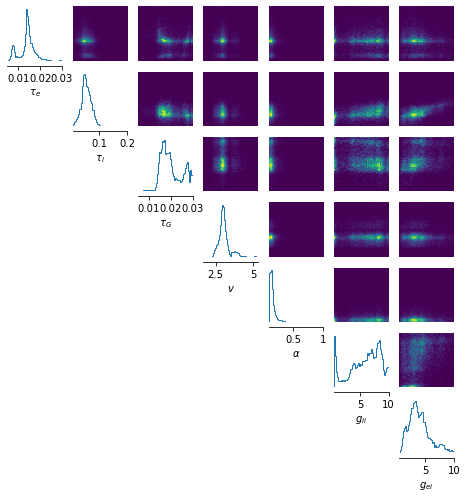

In [26]:

# taue, taui, tauC, speed, alpha, gii, gei
_ = analysis.pairplot(curRes.postSpss[-1], limits=plotLimits, 
                      labels=paras.name_order_latex,
                      figsize=(8,8))

#### Spectral and spatial features estimation

In [63]:
# the estimated spatial feature from MEG
MEGSPs = []
MEGSPRaws = []
for ix in trange(36):
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(DAT_ROOT) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
    
    curMEGSP, curMEGSPRaw = meg_psd2spatialfeature(curBrain.reducedConnectome, ind_psd[:, :, ix], freqs)
    MEGSPs.append(curMEGSP)
    MEGSPRaws.append(curMEGSPRaw.sum(axis=1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 52.45it/s]


In [64]:
# the estimated PSD and spatial feature from SGM 
# for each iteration, we have 10 in total 
for ixfil in tqdm(sorted_fils[:]):
    sgmPSDs = []
    sgmSPs = []
    with open(ixfil, "rb") as f:
        curRes = pickle.load(f)
        
    curEstParas = np.array([np.median(i.numpy(), axis=0) for i in curRes.postSpss])
    #curEstParas = np.array([get_mode_wrap(i) for i in curRes.postSpss])
    for ix in trange(36):
        curParas = curEstParas[ix, :]
        curC = ind_conn[:, :, ix]
        curBrain = Brain.Brain()
        curBrain.add_connectome(DAT_ROOT) # grabs distance matrix
        # re-ordering for DK atlas and normalizing the connectomes:
        curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
        curBrain.connectome = curC# re-assign connectome to individual connectome
        curBrain.bi_symmetric_c()
        curBrain.reduce_extreme_dir()
        
        curSgmModel = Sgm(curBrain.reducedConnectome, curBrain.distance_matrix, freqs)
        curPSD, curSPs = curSgmModel.run_local_coupling_forward(curParas)
        curPSD = curPSD[:68, :]
        curPSD = std_psd(mag2db(np.abs(curPSD)))
        
        sgmPSDs.append(curPSD)
        sgmSPs.append(curSPs.sum(axis=1))
    
    
    
    curRes.sgmPSDs = sgmPSDs
    curRes.sgmSPs = sgmSPs
    with open(ixfil, "wb") as f:
        pickle.dump(curRes, f)

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 34/36 [00:40<00:02,  1.21s/it]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 32/36 [00:38<00:04,  1.22s/it]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 30/36 [00:36<00:07,  1.22s/it]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 28/36 [00:33<00:09,  1.19s/it]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 26/36 [00:31<00:12,  1.21s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [07:16<00:00, 43.65s/it]


In [65]:
corrs = []
PSDs = []
MEGPSDMean = np.mean([std_psd(mag2db(ind_psd[:, :, ix])).mean(axis=0) for ix in range(36)], axis=0)
for ix in trange(len(sorted_fils)):
    with open(sorted_fils[ix], "rb") as f:
        curRes = pickle.load(f)
    curPSD = np.array(curRes.sgmPSDs).mean(axis=1).mean(axis=0)
    cor = scipy.stats.pearsonr(std_vec(MEGPSDMean), std_vec(curPSD))[0]
    corrs.append(cor)
    PSDs.append(curPSD)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.93it/s]


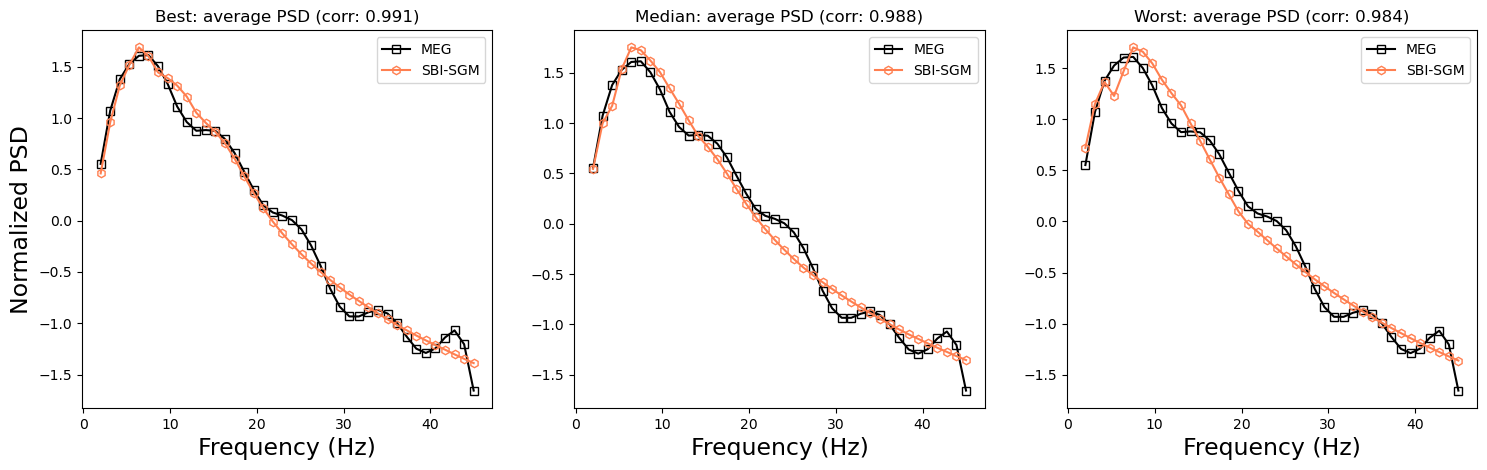

In [29]:
corrs = np.array(corrs)
bestId = np.argmax(corrs)
worstId = np.argmin(corrs)
medId = np.argmin(np.abs(corrs-np.median(corrs)))
titles = ["Best", "Median", "Worst"]
plt.figure(figsize=[18, 5], dpi=100)
for ix, curId in enumerate([bestId, medId, worstId]):
    plt.subplot(1, 3, ix+1)
    plt.title(f"{titles[ix]}: average PSD (corr: {corrs[curId]:.3f})")
    plt.plot(freqs, std_vec(MEGPSDMean), linestyle = '-',marker = 's',
         fillstyle = 'none',color = 'k', 
         label = "MEG")
    plt.plot(freqs, std_vec(PSDs[curId]), linestyle = '-',marker=plot_sets.marker[1],
         fillstyle = 'none',color = plot_sets.col[1], 
         label = metd.SBI)
    plt.xlabel('Frequency (Hz)', fontsize = 17)
    plt.legend()
    if ix == 0:
        plt.ylabel('Normalized PSD', fontsize = 17)
plt.savefig(paras.fig_dir/"PSD_representative.jpg")

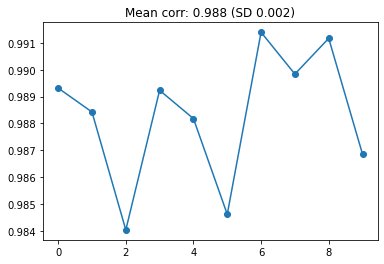

In [32]:
plt.title(f"Mean corr: {corrs.mean():.3f} (SD {corrs.std():.3f})")
plt.plot(corrs, "o-")

#### Corrs for PSD and spatial features for each subject

In [30]:
MEG_psd_each_ROIs = np.array([std_psd(mag2db(ind_psd[:, :, ix])) for ix in range(36)])
PSDCorrss = []

for ix in trange(len(sorted_fils)):
    with open(sorted_fils[ix], "rb") as f:
        curRes = pickle.load(f)
    curSGM_psd_ROIs = np.array(curRes.sgmPSDs)
    PSDCorrs = []
    for iy in range(MEG_psd_each_ROIs.shape[0]):
        curMEG = MEG_psd_each_ROIs[iy]
        curSGM = curSGM_psd_ROIs[iy]
        #PSDCorrs.append(scipy.stats.pearsonr(curMEG, curSGM)[0])
        PSDCorrs.append(np.mean([scipy.stats.pearsonr(curMEG[iz], curSGM[iz])[0] for iz in range(68)]))
    PSDCorrss.append(PSDCorrs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.96it/s]


In [34]:
np.sort(np.array(PSDCorrss).mean(axis=1))

array([0.84613038, 0.85124618, 0.85226097, 0.85704142, 0.86143783,
       0.86239713, 0.86288606, 0.86324295, 0.86431041, 0.86729628])

In [35]:
np.median(np.array(PSDCorrss), axis=1)

array([0.87137587, 0.87951044, 0.88111864, 0.87645015, 0.87487428,
       0.862069  , 0.87676678, 0.8825845 , 0.87449385, 0.87253219])

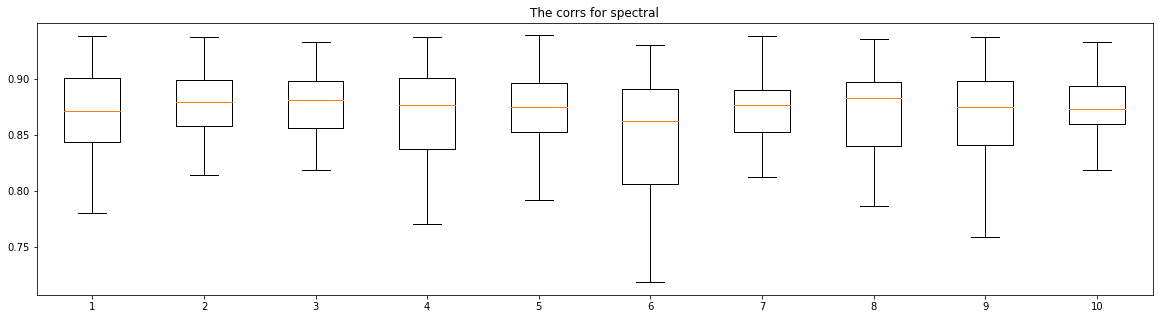

In [36]:
plt.figure(figsize=[20, 5])
plt.title("The corrs for spectral")
_ = plt.boxplot(np.array(PSDCorrss).T, showfliers=False)

In [31]:
SPCorrss = []
for ix in trange(len(sorted_fils)):
    with open(sorted_fils[ix], "rb") as f:
        curRes = pickle.load(f)
    SPCorrs = []
    for mv, ov in zip(curRes.sgmSPs, MEGSPs):
        SPCorrs.append(np.dot(mv/np.linalg.norm(mv), ov))
        #SPCorrs.append(scipy.stats.pearsonr(mv, ov)[0])
    SPCorrss.append(np.array(SPCorrs))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.51it/s]


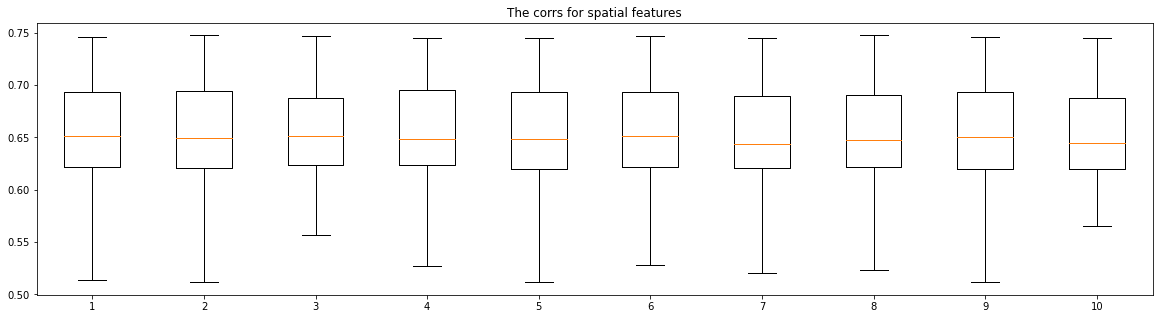

In [38]:
plt.figure(figsize=[20, 5])
plt.title("The corrs for spatial features")
_ = plt.boxplot(np.array(SPCorrss).T, showfliers=False)

### Compare

In [32]:
# my median result
sel_res = edict()

with open(sorted_fils[medId], "rb") as f:
    sel_res.res = pickle.load(f)
    
sel_res.PSD = PSDs[medId]
sel_res.corr = corrs[medId]
sel_res.PSD_corrs = PSDCorrss[medId]
sel_res.SP_corrs = SPCorrss[medId]

In [36]:
# taue, taui, tauC, speed, alpha, gii, gei
para_nams = ["taue", "taui", "tauC", "speed", "alpha", "gii", "gei"]
#para_nams = paras.name_order
def res_2vec(ix=0):
    vec = np.array([anl_res[nam][ix] for nam in para_nams])
    vec[:3] = vec[:3]/1000
    return vec

In [37]:
anl_sgmPSDs = []
anl_sgmSPs = []
for ix in trange(36):
    curParas = res_2vec(ix)
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(DAT_ROOT) # grabs distance matrix
        # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
        
    curSgmModel = Sgm(curBrain.reducedConnectome, curBrain.distance_matrix, freqs)
    curPSD, curSPs = curSgmModel.run_local_coupling_forward(curParas)
    curPSD = curPSD[:68, :]
    curPSD = std_psd(mag2db(np.abs(curPSD)))
        
    anl_sgmPSDs.append(curPSD)
    anl_sgmSPs.append(curSPs.sum(axis=1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:42<00:00,  1.18s/it]


#### PSD curve

In [38]:
MEGPSDMean = np.mean([std_psd(mag2db(ind_psd[:, :, ix])).mean(axis=0) for ix in range(36)], axis=0)
anl_PSD = np.array(anl_sgmPSDs).mean(axis=1).mean(axis=0)
anl_cor = scipy.stats.pearsonr(std_vec(MEGPSDMean), std_vec(anl_PSD))[0]

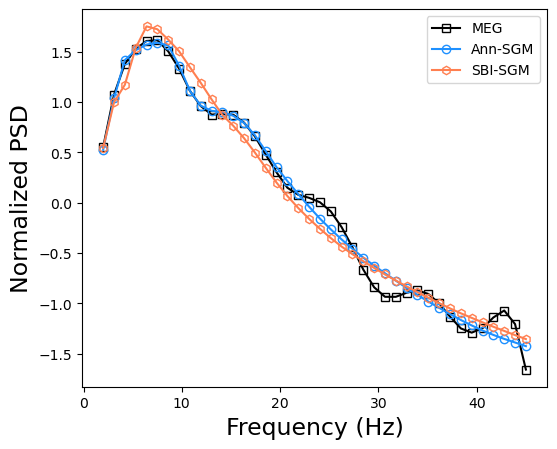

In [39]:
plt.figure(figsize=[6, 5], dpi=100)
plt.plot(freqs, std_vec(MEGPSDMean), linestyle = '-',marker = 's',
         fillstyle = 'none',color = 'k', 
         label = "MEG")
plt.plot(freqs, std_vec(anl_PSD), linestyle = '-',marker=plot_sets.marker[0],
         fillstyle = 'none',color = plot_sets.col[0], 
         label = metd.anl)
plt.plot(freqs, std_vec(sel_res.PSD), linestyle = '-',marker=plot_sets.marker[1],
         fillstyle = 'none',color = plot_sets.col[1], 
         label = metd.SBI)
plt.xlabel('Frequency (Hz)', fontsize = 17)
plt.ylabel('Normalized PSD', fontsize = 17)
plt.legend()

plt.savefig(paras.fig_dir/"PSD_compare.jpg")

In [40]:
MEG_psd_each_ROIs = np.array([std_psd(mag2db(ind_psd[:, :, ix])) for ix in range(36)])
anl_PSD_corrs = []
for ix in range(MEG_psd_each_ROIs.shape[0]):
    curMEG = MEG_psd_each_ROIs[ix]
    curSGM = anl_sgmPSDs[ix]
    anl_PSD_corrs.append(np.mean([scipy.stats.pearsonr(curMEG[iz], curSGM[iz])[0] for iz in range(68)]))

In [41]:
anl_SP_corrs = []
for mv, ov in zip(anl_sgmSPs, MEGSPs):
    anl_SP_corrs.append(np.dot(mv/np.linalg.norm(mv), ov))

#### PSD and SP corrs

In [42]:
SP_both = np.array([anl_SP_corrs, sel_res.SP_corrs])
PSD_both = np.array([anl_PSD_corrs, sel_res.PSD_corrs])

In [ ]:
# not use it
for ix in range(SP_both.shape[-1]):
    plt.plot([0, 1], SP_both[:, ix], "-", color="cyan", alpha=0.8)
    
for ix in range(SP_both.shape[-1]):
    plt.plot([2, 3], PSD_both[:, ix], "-", color="cyan", alpha=0.8)
    
plt.plot([0]*36, SP_both[0, :],
         marker=plot_sets.marker[0], 
         linestyle="", 
         color=plot_sets.col[0])

plt.plot([1]*36, SP_both[1, :],
         marker=plot_sets.marker[1], 
         linestyle="", 
         color=plot_sets.col[1])

plt.plot([2]*36, PSD_both[0, :],
         marker=plot_sets.marker[0], 
         linestyle="", 
         color=plot_sets.col[0])

plt.plot([3]*36, PSD_both[1, :],
         marker=plot_sets.marker[1], 
         linestyle="", 
         color=plot_sets.col[1])

plt.xticks([0.5, 2.5], ["Spatial Corr", "PSD Corr"])

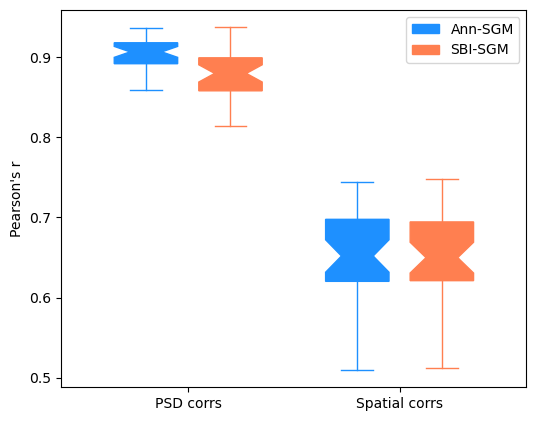

In [43]:
plt.figure(figsize=[6, 5], dpi=100)
box = plt.boxplot(PSD_both.T[:, 0], positions=[0.4],
                  notch=True, showfliers=False,  patch_artist=True);
for item in ['boxes', 'whiskers',  'medians', 'caps']:
    plt.setp(box[item], color=plot_sets.col[0])
box1 = box
    
box = plt.boxplot(PSD_both.T[:, 1], positions=[0.6],
                  notch=True, showfliers=False,  patch_artist=True);
for item in ['boxes', 'whiskers',  'medians', 'caps']:
    plt.setp(box[item], color=plot_sets.col[1])
box2 = box
    
box = plt.boxplot(SP_both.T[:, 0], positions=[.9],
                  notch=True, showfliers=False,  patch_artist=True);
for item in ['boxes', 'whiskers',  'medians', 'caps']:
    plt.setp(box[item], color=plot_sets.col[0])
    
box = plt.boxplot(SP_both.T[:, 1], positions=[1.1],
                  notch=True, showfliers=False,  patch_artist=True);
for item in ['boxes', 'whiskers',  'medians', 'caps']:
    plt.setp(box[item], color=plot_sets.col[1])
plt.xlim([0.2, 1.3])

plt.xticks([0.5, 1], ["PSD corrs", "Spatial corrs"])
plt.ylabel("Pearson's r")
plt.legend([box1["boxes"][0], box2["boxes"][0]], [metd.anl, metd.SBI])
plt.savefig(paras.fig_dir/"corr_boxplots.jpg")

#### Brain plots

In [231]:
minmax_vec5 = lambda x: 4*minmax_vec(x)+1
vec_2plot = lambda x: U2BrainVec(reorderU(minmax_vec5(x)))

anl_overall_sp =  np.mean([ix / np.linalg.norm(ix) for ix in anl_sgmSPs], axis=0)
sbi_overall_sp =  np.mean([ix / np.linalg.norm(ix) for ix in sel_res.res.sgmSPs], axis=0)

#anl_overall_sp = np.mean(anl_sgmSPs, axis=0)
#sbi_overall_sp = np.mean(sel_res.res.sgmSPs, axis=0)
obs_overall_sp = np.mean(MEGSPRaws, axis=0)

np.savetxt(paras.res_dir/f"./sbi_sp_overall.txt", vec_2plot(sbi_overall_sp))
np.savetxt(paras.res_dir/f"./anl_sp_overall.txt", vec_2plot(anl_overall_sp))
np.savetxt(paras.res_dir/f"./obs_sp_overall.txt", vec_2plot(obs_overall_sp))

#### Posterior sps

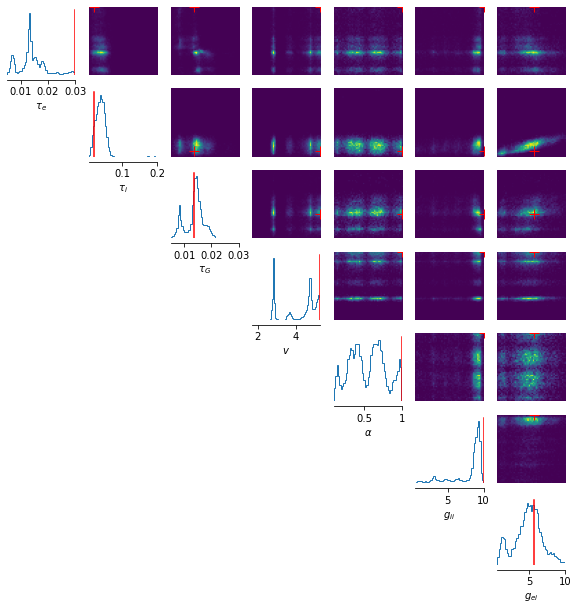

In [44]:
cur_ind_psd = np.argmin(np.abs(sel_res.PSD_corrs-np.mean(sel_res.PSD_corrs)))
# taue, taui, tauC, speed, alpha, gii, gei
_ = analysis.pairplot(sel_res.res.postSpss[cur_ind_psd], 
                      points=res_2vec(cur_ind_psd),
                      points_colors="red",
                      points_offdiag=dict(marker="+", markersize=10),
                      limits=plotLimits, 
                      #upper="scatter",
                      #scatter_offdiag=dict(marker=".", s=5),
                      labels=paras.name_order_latex,
                      figsize=(10,10), dpi=100)
plt.savefig(paras.fig_dir/f"postsps_ex{cur_ind_psd}.jpg")

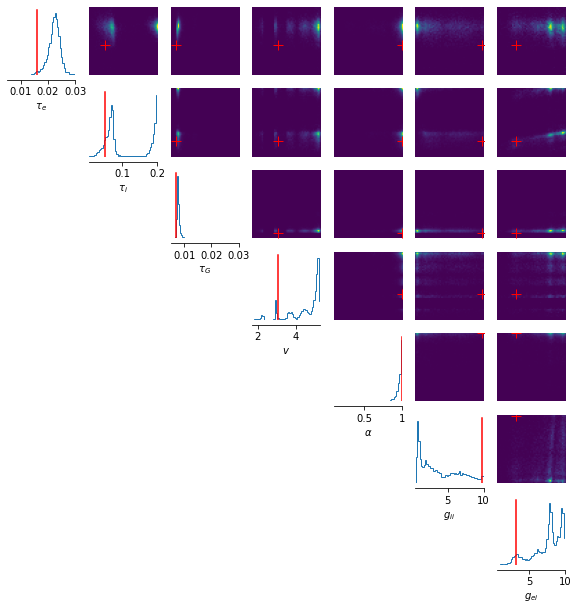

In [45]:
cur_ind_psd = np.argmin(np.abs(sel_res.PSD_corrs-np.median(sel_res.PSD_corrs)))
# taue, taui, tauC, speed, alpha, gii, gei
_ = analysis.pairplot(sel_res.res.postSpss[cur_ind_psd], 
                      points=res_2vec(cur_ind_psd),
                      points_colors="red",
                      points_offdiag=dict(marker="+", markersize=10),
                      limits=plotLimits, 
                      #upper="scatter",
                      #scatter_offdiag=dict(marker=".", s=5),
                      labels=paras.name_order_latex,
                      figsize=(10,10), dpi=100)
plt.savefig(paras.fig_dir/f"postsps_ex{cur_ind_psd}.jpg")

### Diagnosis

#### Predictive checks

The dim of output is too high to check

In [446]:
cur_ind_psd = np.argmin(np.abs(sel_res.PSD_corrs-np.median(sel_res.PSD_corrs)))
post_psds = []
post_sps = []
for ix in trange(0, 10000, 10):
    cur_paras = sel_res.res.postSpss[cur_ind_psd][ix, :]
    curC = ind_conn[:, :, cur_ind_psd]
    curBrain = Brain.Brain()
    curBrain.add_connectome(DAT_ROOT) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
    
    curSgmModel = Sgm(curBrain.reducedConnectome, curBrain.distance_matrix, freqs)
    curPSD, curSPs = curSgmModel.run_local_coupling_forward(cur_paras)
    curPSD = curPSD[:68, :]
    
    simuout_PSD = std_psd(mag2db(np.abs(curPSD)))
    simuout_SP = curSPs.sum(axis=1)
    post_psds.append(simuout_PSD)
    post_sps.append(simuout_SP)
    
with open(paras.res_dir/f"post_PSDxSP_{cur_ind_psd}.pkl", "wb") as f:
    pickle.dump([post_psds, post_sps], f)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [20:11<00:00,  1.21s/it]


In [186]:
cur_ind_psd = np.argmin(np.abs(sel_res.PSD_corrs-np.median(sel_res.PSD_corrs)))
with open(paras.res_dir/f"post_PSDxSP_{cur_ind_psd}.pkl", "rb") as f:
    post_psds, post_sps = pickle.load(f)

In [187]:
sp, raw_sps = meg_psd2spatialfeature(curBrain.reducedConnectome, ind_psd[:, :, cur_ind_psd], freqs, band="alpha")
obs_meg_sp = raw_sps.sum(axis=1)
obs_meg_sp = std_vec(raw_sps.sum(axis=1))
obs_meg_psd = std_vec(std_psd(mag2db(ind_psd[:, :, cur_ind_psd])).mean(axis=0))

In [188]:
post_psds_m = np.array([std_vec((post_psds[ix]+np.random.randn(68, 40)*0.0).mean(axis=0)) for ix in range(len(post_psds))])
post_sps1 = np.array([std_vec(post_sps[ix])+np.random.randn(68)*0.0 for ix in range(len(post_sps))])

In [52]:
# psd check (Test is not good)
pvs = []
for ix in range(40):
    cur_sps = post_psds_m[:, ix]
    full_sps = np.concatenate([cur_sps, [obs_meg_psd[ix]]])
    dist = np.abs(full_sps.reshape(-1, 1) - full_sps.reshape(1, -1)).mean(axis=0)
    pv = np.min([np.mean(dist[:-1] <= dist[-1]), np.mean(dist[:-1] >= dist[-1])])
    pvs.append(pv)
pvs = np.array(pvs)
np.sum(pvs>0.05)

29

In [53]:
# sp check (Test is not good)
pvs = []
for ix in range(68):
    cur_sps = post_sps1[:, ix]
    full_sps = np.concatenate([cur_sps, [obs_meg_sp[ix]]])
    dist = np.abs(full_sps.reshape(-1, 1) - full_sps.reshape(1, -1)).mean(axis=0)
    pv = np.min([np.mean(dist[:-1] <= dist[-1]), np.mean(dist[:-1] >= dist[-1])])
    pvs.append(pv)
pvs = np.array(pvs)
np.sum(pvs>0.05)

11

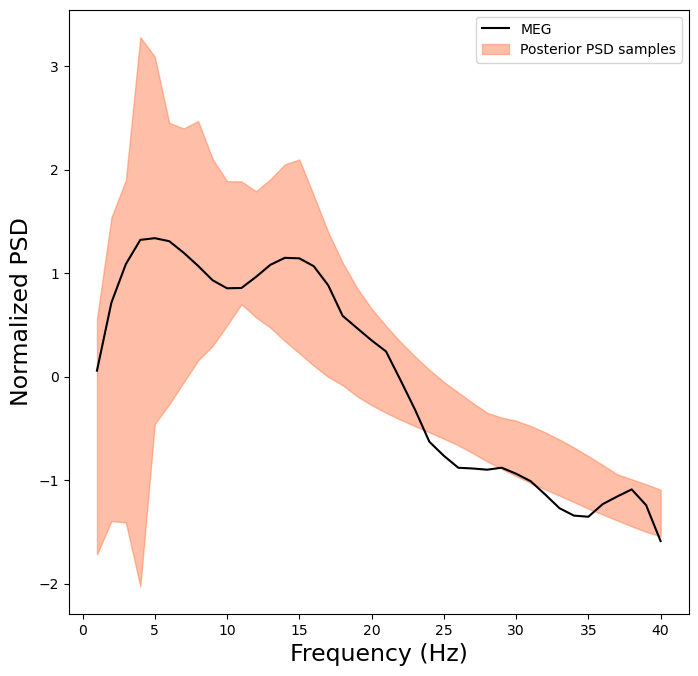

In [189]:
# PSD plot
plt.figure(figsize=[8, 8], dpi=100)
lows, ups = np.quantile(post_psds_m, [0.001, 0.999], axis=0)
plt.fill_between(np.arange(1, 41), lows, ups, color=plot_sets.col[1], alpha=0.5, label="Posterior PSD samples")
plt.plot(np.arange(1, 41), obs_meg_psd, color='black', label="MEG")
plt.legend()
plt.xlabel('Frequency (Hz)', fontsize = 17)
plt.ylabel('Normalized PSD', fontsize = 17)
plt.savefig(paras.fig_dir/f"post_PSDs_ex{cur_ind_psd}.jpg")

In [124]:
minmax_vec5 = lambda x: 4*minmax_vec(x)+1
vec_2plot = lambda x: U2BrainVec(reorderU(minmax_vec5(x)))
# get results for plotting
sbi_out_sp = sel_res.res.sgmSPs[cur_ind_psd]
anl_out_sp = anl_sgmSPs[cur_ind_psd]
post_mean_sp = np.array(post_sps).mean(axis=0)
obs_meg_sp = raw_sps.sum(axis=1)

np.savetxt(paras.res_dir/f"./sbi_sp_{cur_ind_psd}.txt", vec_2plot(sbi_out_sp))
np.savetxt(paras.res_dir/f"./anl_sp_{cur_ind_psd}.txt", vec_2plot(anl_out_sp))
np.savetxt(paras.res_dir/f"./post_sp_{cur_ind_psd}.txt", vec_2plot(post_mean_sp))
np.savetxt(paras.res_dir/f"./obs_sp_{cur_ind_psd}.txt", vec_2plot(obs_meg_sp))

#### Conditional distribution

In [190]:
curC = ind_conn[:, :, cur_ind_psd]
curBrain = Brain.Brain()
curBrain.add_connectome(DAT_ROOT) # grabs distance matrix
# re-ordering for DK atlas and normalizing the connectomes:
curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
curBrain.connectome = curC# re-assign connectome to individual connectome
curBrain.bi_symmetric_c()
curBrain.reduce_extreme_dir()
        
sp, raw_sps = meg_psd2spatialfeature(curBrain.reducedConnectome, ind_psd[:, :, cur_ind_psd], freqs, band="alpha")
stdSp = std_vec(raw_sps.mean(axis=1))
stdPsd = std_psd(mag2db(ind_psd[:, :, cur_ind_psd])).flatten()
curX = torch.Tensor(np.concatenate([stdPsd, stdSp]))
cur_sps = sel_res.res.postSpss[cur_ind_psd][::10, :]
cur_posterior = sel_res.res.posterior.set_default_x(curX)

In [191]:
cur_cond_corr_mat = analysis.conditional_corrcoeff(density=cur_posterior, 
                                                   condition=cur_sps,
                                                   limits=torch.Tensor(plotLimits))
with open(paras.res_dir/f"cond_corr_{cur_ind_psd}.pkl", "wb") as f:
    pickle.dump(cur_cond_corr_mat, f)

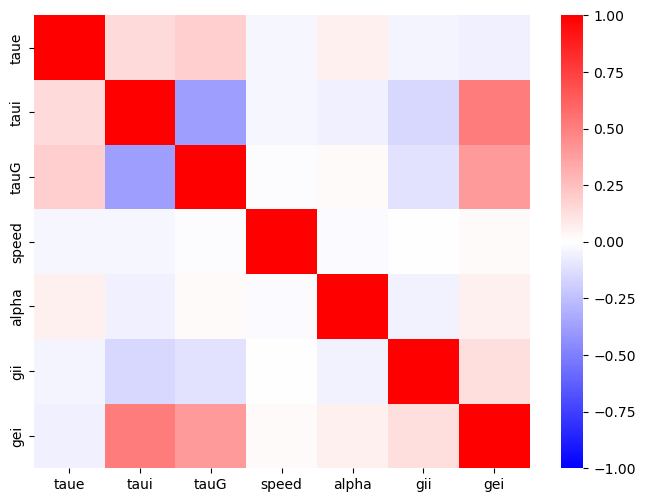

In [192]:
plt.figure(figsize=[8, 6], dpi=100)
sns.heatmap(cur_cond_corr_mat, vmin=-1, vmax=1, cmap="bwr")
plt.xticks(np.arange(7)+0.5, paras.name_order)
plt.yticks(np.arange(7)+0.5, paras.name_order);
plt.savefig(paras.fig_dir/f"cond_corr_{cur_ind_psd}.jpg");

In [ ]:
# obtain conditional corr mat for all subjects
for ix in trange(36):
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(DAT_ROOT) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
            
    sp, raw_sps = meg_psd2spatialfeature(curBrain.reducedConnectome, ind_psd[:, :, ix], freqs, band="alpha")
    stdSp = std_vec(raw_sps.mean(axis=1))
    stdPsd = std_psd(mag2db(ind_psd[:, :, ix])).flatten()
    curX = torch.Tensor(np.concatenate([stdPsd, stdSp]))
    cur_sps = sel_res.res.postSpss[ix][::50, :]
    cur_posterior = sel_res.res.posterior.set_default_x(curX)
    
    cur_cond_corr_mat = analysis.conditional_corrcoeff(density=cur_posterior, 
                                                       condition=cur_sps,
                                                       limits=torch.Tensor(plotLimits))
    with open(paras.res_dir/f"cond_corr_{ix}.pkl", "wb") as f:
        pickle.dump(cur_cond_corr_mat, f)

  0%|                                                                                                                                                                                        | 0/36 [00:00<?, ?it/s]

In [46]:
corr_fils = list(paras.res_dir.glob("cond_corr_*.pkl"))
sorted_corr_fils = sorted(corr_fils, key=lambda x: int(x.stem.split("_")[-1]))
corr_mats = []
for ix_fil in sorted_corr_fils:
    with open(ix_fil, "rb") as f:
        cur_mat = pickle.load(f)
    corr_mats.append(cur_mat.numpy())

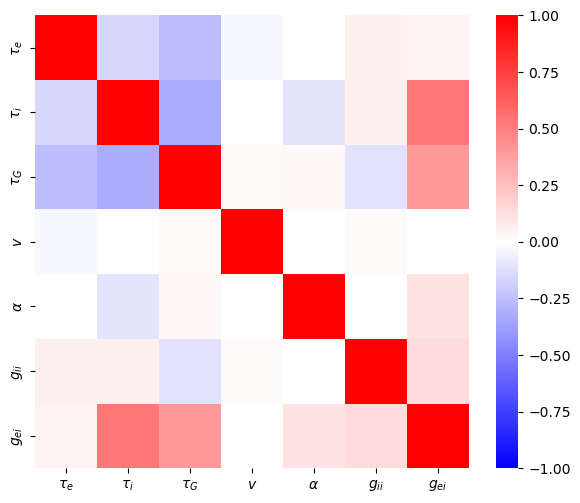

In [48]:
plt.figure(figsize=[7, 6], dpi=100)
sns.heatmap(np.mean(corr_mats, axis=0), vmin=-1, vmax=1, cmap="bwr")
plt.xticks(np.arange(7)+0.5, paras.name_order_latex)
plt.yticks(np.arange(7)+0.5, paras.name_order_latex);
plt.savefig(paras.fig_dir/f"cond_corr_all_mean.jpg");

### Others

In [76]:
### Save the point estimate from one trained model
pt_SBI_SGM = []
for postSps in sel_res.res.postSpss:
    pt_SBI_SGM.append(np.median(postSps.numpy(), axis=0))
paras.name_order
pt_SBI_SGM = np.array(pt_SBI_SGM)
pt_SBI_SGM = {paras.name_order[ix]:pt_SBI_SGM[:, ix] for ix in range(7)}

In [82]:
out = pd.DataFrame(pt_SBI_SGM)
out.to_csv(paras.res_dir/"SBISGM_point_estimate.csv")